<a href="https://colab.research.google.com/github/alexdibol/ML_FINANCE_TRAINING/blob/master/Copia_de_USING_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> USING RESNET </center>

https://blog.jovian.ai/using-resnet-for-image-classification-4b3c42f2a27e


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os

In [ ]:
# Look into the data directory
data_dir = '/content/drive/MyDrive/Colab Notebooks/TOPIC_9_USING RESNET FOR IMAGE CLASSIFICATION/data'
#print(os.listdir(data_dir))

#Training data directory
train_dir = (data_dir + '/seg_train/seg_train')
print('Classes:')
print(os.listdir(train_dir))

#Test data directory
test_dir = (data_dir + '/seg_test/seg_test')
#print(os.listdir(test_dir))

#pred_dir = (data_dir + '/seg_pred/seg_pred')

Classes:
['glacier', 'forest', 'buildings', 'sea', 'mountain', 'street']


In [ ]:
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset

In [ ]:
#Transformations aplied to test DS.
train_tf = tt.Compose([         
    tt.ColorJitter(brightness=0.2),
    tt.Resize(size=(150,150)),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(5),
    tt.ToTensor(),            
])

#Transformations aplied to test DS.
test_tf= tt.Compose([   
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

In [ ]:
train_ds = ImageFolder(train_dir,train_tf)
test_ds = ImageFolder(test_dir,test_tf)

len(train_ds), len(test_ds)

(14034, 3000)

In [ ]:
img,label=train_ds[0]
img.shape

torch.Size([3, 150, 150])

In [ ]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))
    

In [ ]:
print('Training dataset information:')
ds_info(train_ds)

Training dataset information:
Size of the dataset:14034
Number of classes:6
Samples for every class:
buildings : 2191
forest : 2271
glacier : 2404
mountain : 2512
sea : 2274
street : 2382


In [ ]:
print('Test dataset information:')
ds_info(test_ds)

Test dataset information:
Size of the dataset:3000
Number of classes:6
Samples for every class:
buildings : 437
forest : 474
glacier : 553
mountain : 525
sea : 510
street : 501


In [ ]:
batch_size = 254

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=False,
    pin_memory=True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


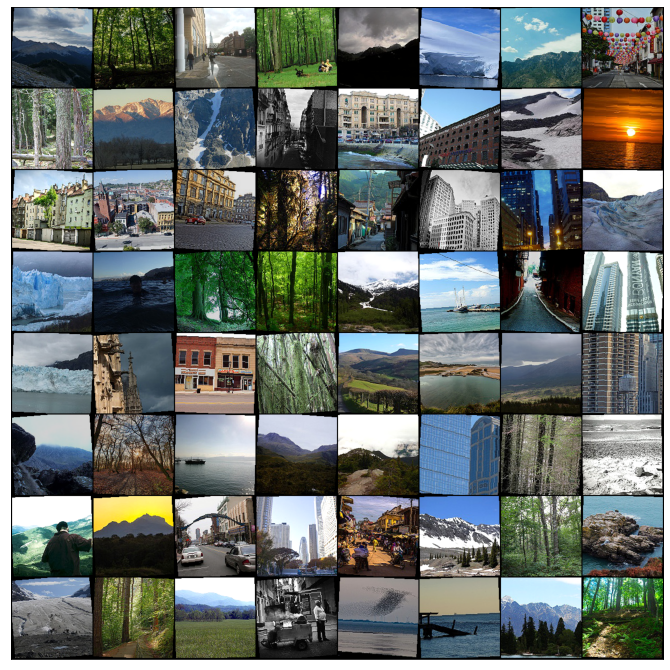

In [ ]:
%matplotlib inline
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device() #Getting the device
device

train_dl = DeviceDataLoader(train_dl, device) #Transfering train data to GPU
test_dl = DeviceDataLoader(test_dl, device)   #Transfering test data to GPU

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

In [ ]:
class Resnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,test_ds.classes[preds[0].item()])

In [ ]:
model = to_device(ResNet9(3,6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [ ]:
history = [evaluate(model, test_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.15616798400878906, 'val_loss': 1.7933281660079956}]

In [ ]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/56 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1], last_lr: 0.00027, train_loss: 0.9736, val_loss: 0.8254, val_acc: 0.6967


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00076, train_loss: 0.5676, val_loss: 1.8942, val_acc: 0.4742


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00100, train_loss: 0.4666, val_loss: 0.8240, val_acc: 0.7077


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00095, train_loss: 0.3909, val_loss: 0.9111, val_acc: 0.7054


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00081, train_loss: 0.3378, val_loss: 1.3532, val_acc: 0.6249


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00061, train_loss: 0.2950, val_loss: 0.5332, val_acc: 0.8105


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00039, train_loss: 0.2510, val_loss: 0.3226, val_acc: 0.8908


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00019, train_loss: 0.2241, val_loss: 0.2952, val_acc: 0.9007


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00005, train_loss: 0.1866, val_loss: 0.3022, val_acc: 0.8965


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00000, train_loss: 0.1707, val_loss: 0.2709, val_acc: 0.9082
CPU times: user 4h 3min 40s, sys: 8min 26s, total: 4h 12min 6s
Wall time: 4h 16min 4s


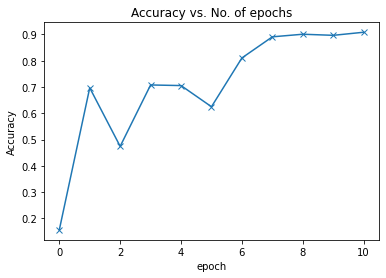

In [ ]:
plot_scores(history)

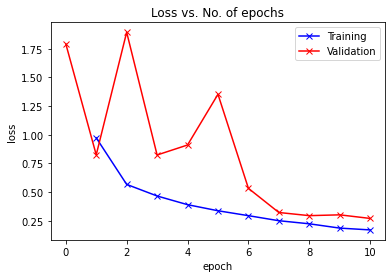

In [ ]:
plot_losses(history)

Labels: mountain


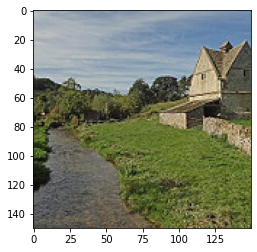

In [ ]:
predict_image(test_ds[5][0],model)

Labels: forest


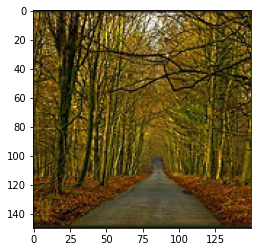

In [ ]:
predict_image(test_ds[505][0],model)

Labels: glacier


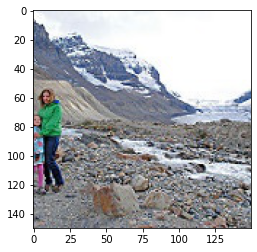

In [ ]:
predict_image(test_ds[1005][0],model)

In [ ]:
model = to_device(Resnet34(), device)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Resnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
history = [evaluate(model, test_dl)]
history

In [ ]:
epochs = 5
epochs2 = 5
max_lr2 = 0.00005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
model.freeze()

In [ ]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
plot_scores(history)

In [ ]:
plot_losses(history)

In [ ]:
predict_image(test_ds[5][0],model)

In [ ]:
predict_image(test_ds[505][0],model)

In [ ]:
predict_image(test_ds[1005][0],model)

In [ ]:
!pip install jovian --upgrade --quiet
import jovian
jovian.reset()
project_name='Project'
jovian.commit(project=project_name, environment=None)